<a href="https://colab.research.google.com/github/xcomponent/chatbot-nlp/blob/main/identify_similar_intents_by_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identify similar intents groups by clustering on semantic features

Two characteristics of our training data:  
- large number of intents (classes)
- very similar intents : very similar phrases can have different intent labels

In this context, we sometimes get the poor intent detection performance. Especially, many false positifs are detected. 

To improve the performance, we think to classify messages in 2 steps :

1.   identify message belonging to a group (cluster) of intents
2.   in a group, identify message belonging to which intent

This method only works when we are able to split our training data into separated clusters. Each intent belongs only to one cluster. 

This study aims to check if our data can be separated into distinguished clusters. 

Also, we want a better handle of out-of-training-scope phrase, we thus use BERT features and identify clusters on them.




In [2]:
from google.colab import drive
drive.mount('/colab-data-drive')

Mounted at /colab-data-drive


In [1]:
!pip install transformers
!pip install sentencepiece
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 13.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=18fc8f6a60a0dcfe346b37349bfe424f86cc34ff0b5ef33e54cdc2a752b46c09
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342be

In [3]:
import pandas
import numpy as np
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

import sentence_transformers
from sentence_transformers import SentenceTransformer, util

import torch

from collections import Counter

In [4]:
def load_training_text(testing_data_fn):

    messages = []

    df = pandas.read_excel(testing_data_fn)

    return df

# Load data

### Training data

In [6]:

testing_data_fn=r"/colab-data-drive/MyDrive/Colab Notebooks/data/training_data/62d96ac33ab410de33a831ff_training_data_FR.xlsx"

df = load_training_text(testing_data_fn)

all_messages = []
all_intents = []

for i, row in df.iterrows():
  message, intent, intent_name = row
  all_messages.append(message)
  all_intents.append(intent_name)

print(f"Training data has {len(all_messages)} message")
print(f"Training data contains {len(set(all_intents))} intents")

Training data has 762 message
Training data contains 71 intents


## Select subset of data to study

In [7]:
nb_samples = 100

messages = all_messages[:nb_samples]
intents = all_intents[:nb_samples]

all_intents_name = list(set(intents))

nb_phrases_in_intents = Counter(intents)

print(f'Data to study has : {len(all_intents_name)} intents')
for name, count in nb_phrases_in_intents.items():
    print(f"\t{name} : {count}")

Data to study has : 12 intents
	Demander de l'aide : 5
	Arrêter conversation : 6
	TOREVIEW Demander qui peut acheter sur PFS : 5
	TOREVIEW Demander politique de confidentialité : 5
	TOREVIEW Demander application : 6
	TOREVIEW Rechercher produit : 5
	TO REVIEW Demander contact service : 14
	MK- Indiquer colis endommagé : 20
	MK - Demander quoi faire si colis non reçu : 9
	Demander statut commande : 6
	Demander information contact entreprise : 17
	utilisateur souhaite connaitre l'heure : 2


In [ ]:
# ## create test data baseline

# messages = all_messages[652:678] + all_messages[602:615] + all_messages[5:11]
# intents = all_intents[652:678] + all_intents[602:615] + all_intents[5:11]

# all_intents_name = list(set(intents))
# print(all_intents_name)

# nb_phrases_in_intents = Counter(intents)
# print(nb_phrases_in_intents)

# print(messages)


# Visualize data

## Number training per class

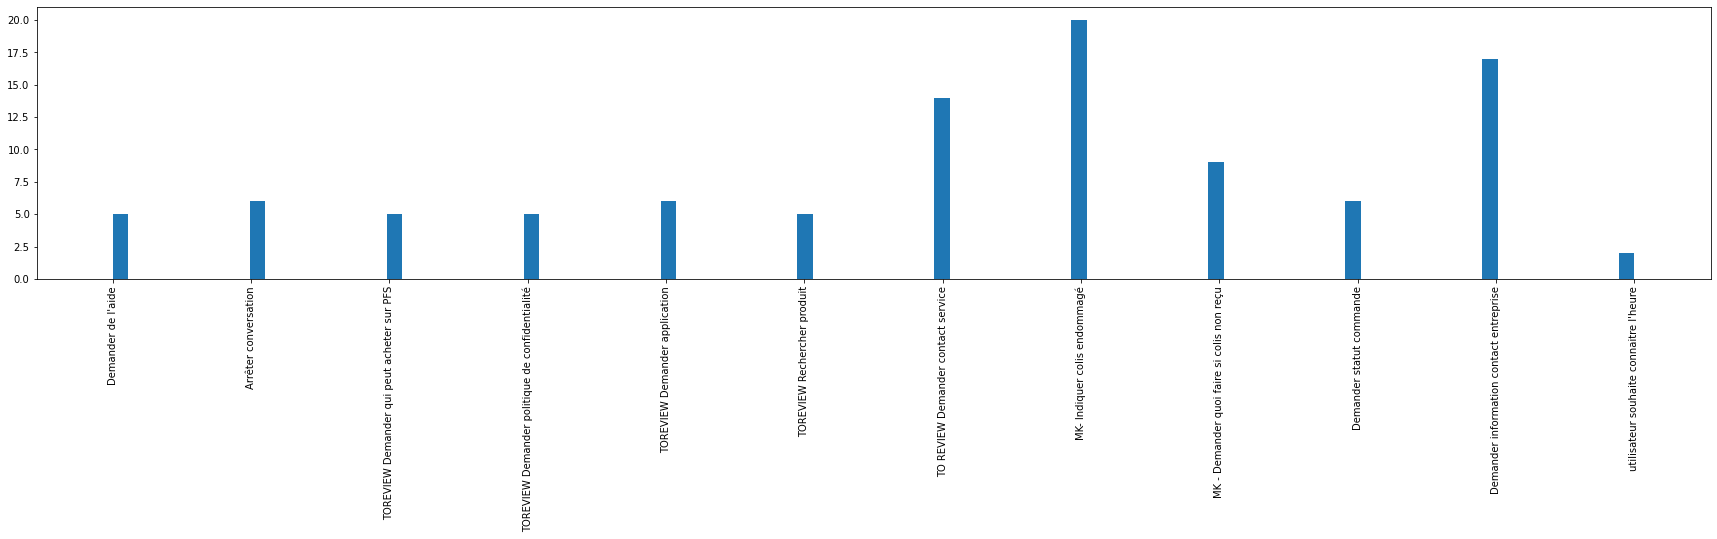

In [8]:
plt.figure(figsize=(30,5))
plt.hist(intents, bins=len(intents))
plt.xticks(rotation='vertical')
plt.show()

# k-means clustering on BERT features

## Extract BERT features

In [9]:
from transformers import CamembertConfig, CamembertModel, CamembertTokenizer

# pre_trained_model = "camembert/camembert-base-wikipedia-4gb"
pre_trained_model = "camembert-base"

config = CamembertConfig.from_pretrained(pre_trained_model, output_hidden_states=True)
camembert = CamembertModel.from_pretrained(pre_trained_model, config=config)
tokenizer = CamembertTokenizer.from_pretrained(pre_trained_model, do_lower_case=True)


Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/811k [00:00<?, ?B/s]

In [10]:
def embedding(message):
  tokenized_sentence = tokenizer.tokenize(message)

  encoded_sentence = tokenizer.encode(tokenized_sentence)
  encoded_sentence = torch.tensor(encoded_sentence).unsqueeze(0)

  # last hidden layer
  res = camembert(encoded_sentence)[0].squeeze()

  embedding_features = res[0].tolist()

  return embedding_features

In [11]:
def extract_bert_features(messages):

  features = []

  for i, message in enumerate(messages):
    features.append(embedding(message))
    
    if i > 0 and i % 50 == 0: 
      print(f"Extracting features of {i}th message : {round(i/len(messages) * 100, 2) }% done")


  print(f"\nNumber of embedded messages : {len(features)}")
  print(f"Embedding size : {len(features[0])}")

  return features

In [12]:
bert_features = extract_bert_features(messages)

Extracting features of 50th message : 50.0% done

Number of embedded messages : 100
Embedding size : 768


In [14]:
for i in range(5):
  print(bert_features[i])

[-0.07053525745868683, 0.030486924573779106, 0.09839709103107452, -0.11704474687576294, -0.042256951332092285, 0.0486721508204937, -0.011302294209599495, 0.3025948107242584, 0.06026128679513931, 0.12002351135015488, 0.018632521852850914, 0.0672757476568222, 0.005302405916154385, 0.11446239054203033, 0.26375991106033325, -0.05891551822423935, 0.06468459218740463, -0.04999310150742531, 0.09665292501449585, -0.19433742761611938, 0.06490491330623627, -0.06332273781299591, 0.05269716680049896, -0.33415213227272034, 0.09631147980690002, -0.24424926936626434, -0.049914631992578506, -0.06463496387004852, -0.02629896067082882, 0.03362694010138512, 0.026194104924798012, -0.21739831566810608, 0.18375268578529358, 0.15129265189170837, 0.13209550082683563, -0.06717559695243835, -0.1055326908826828, 0.20070424675941467, -0.06436869502067566, -0.0421818345785141, -0.30305713415145874, 0.10980617254972458, 0.17914769053459167, -0.05898170918226242, 0.007210730575025082, 0.2389758974313736, -0.20910581

## k-means clustering



In [15]:
def k_means_clustering(features, num_clusters):

    clustering_model = KMeans(n_clusters=num_clusters, random_state=42)
    clustering_model.fit(features)
    cluster_assignment = clustering_model.labels_

    clustered_messages = [[] for i in range(num_clusters)]

    cluster_intents = {}

    for message_id, cluster_id in enumerate(cluster_assignment):
        clustered_messages[cluster_id].append((messages[message_id], intents[message_id]))

    for i, cluster in enumerate(clustered_messages):

        intents_in_cluster = [i for m, i in cluster]
        intents_counter = Counter(intents_in_cluster)

        print(f"Cluster {i+1}")
        print(f"\t{len(cluster)} phrases")
        print(f"\t{len(intents_counter)} classes")

        intents_ = {}

        for intent_, count_ in intents_counter.items():
          print(f"\t\t{intent_} : {count_}")
          messages_ = [m for m, i in cluster if i == intent_]
          display = '\n\t\t\t'.join(messages_)
          print(f"\t\t\t{display}")

          intents_[intent_] = count_

        cluster_intents[i+1] = intents_

    return cluster_intents    

In [25]:
def visualize_kmeans_clusters(cluster_intents):
    intents_array = []
    clusters_array = []
    labels_array = []

    for cluster_id, intents_in_cluster in cluster_intents.items():
        for intent_ in all_intents_name:
            intents_array.append(intent_)
            clusters_array.append(cluster_id)
            if intent_ in intents_in_cluster:
                labels_array.append(round(intents_in_cluster[intent_] / nb_phrases_in_intents[intent_], 2))
            else:
                labels_array.append(0)

    df = pandas.DataFrame.from_dict(np.array([intents_array, clusters_array, labels_array]).T)
    df.columns = ['intents','clusters','labels']
    df['labels'] = pandas.to_numeric(df['labels'])

    pivotted= df.pivot('clusters','intents','labels')

    plt.figure(figsize=(30,7))
    plt.title("Distribution of intent's phrases over clusters", {"fontsize": 20})
    sns.heatmap(pivotted, annot=True, cmap='RdBu')
    plt.show()

In [27]:
nb_clusters = 3
cluster_intents = k_means_clustering(bert_features, nb_clusters)

Cluster 1
	15 phrases
	1 classes
		MK- Indiquer colis endommagé : 15
			Mon colis est endommagé
			Mon paquet est abîmé
			Ma livraison est détériorée
			Mon colis est écorné
			Mon colis a un trou sur le côté
			J'ai reçu un colis avec du scotch GLS
			Le carton du colis est gondolé
			j'ai reçu un colis endommagé
			On m'a livré un carton gondolé
			mon colis est abimé
			j'ai reçu mon colis abîmé
			Quand j'ai reçu mon colis, celui ci était complètement endommagé.
			le colis que j'ai reçu est complètement abimé
			J'ai reçu mon colis abimé
			Le transporteur a voulu me laisser un carton  abimé
Cluster 2
	64 phrases
	11 classes
		Arrêter conversation : 5
			quitter conversation
			fin de conversation
			arrête
			stop
			je veux arrêter la conversation
		TOREVIEW Demander qui peut acheter sur PFS : 5
			Je suis un particulier 
			La plateforme est elle ouverte à tous ?
			tout le monde peut acheter ?
			qui peut acheter sur votre plateforme
			je peux acheter ?
		TOREVIEW Demander p

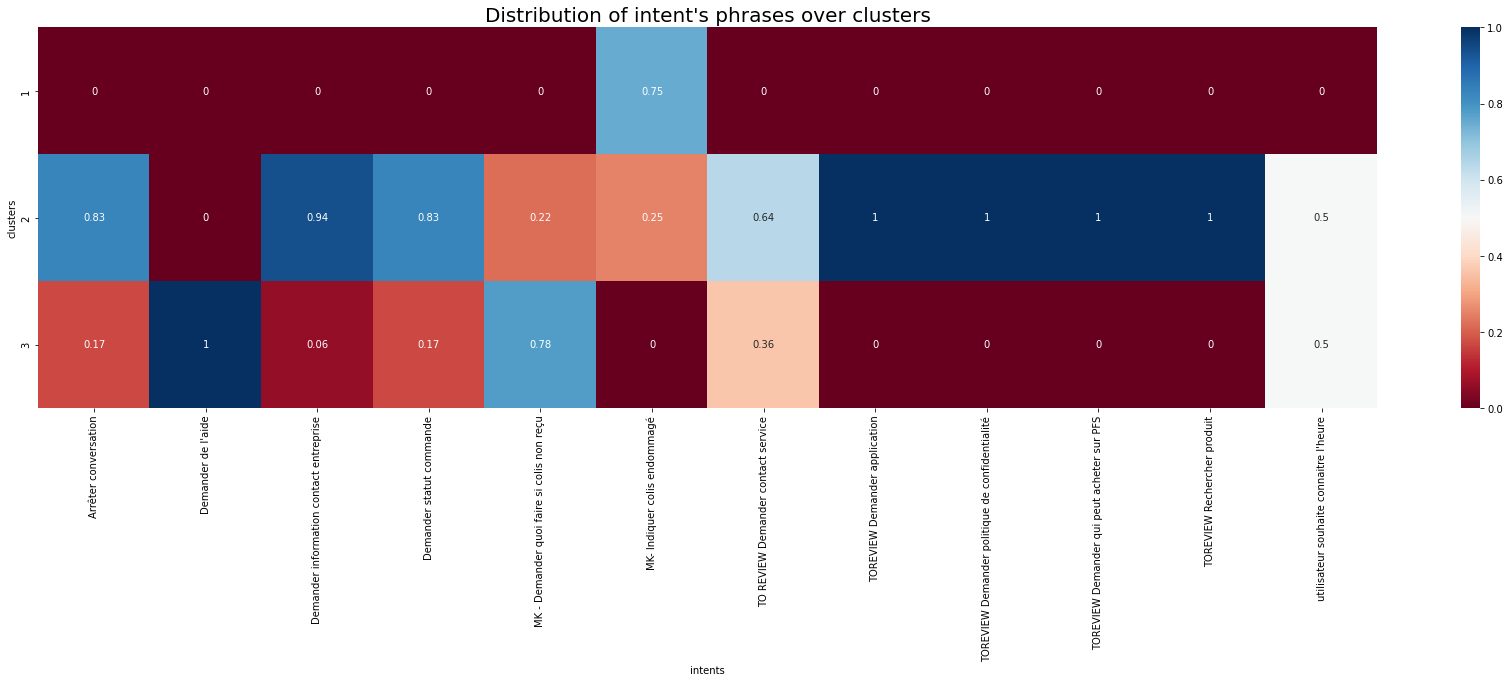

In [29]:
visualize_kmeans_clusters(cluster_intents)

While doing clustering, we expect having separated clusters, i.e. all instances (phrases) of an intent must are located in only one cluster. 

The above chart shows that it is the case for the intents like "Demander de l'aide", "TOREVIEW Demander application", "TOREVIEW DEmander politique de confidentialité", .. where 100% (figured by "1") data is included in a cluster.

For other intents, such as "Arrêter conversation", 83% of data belongs to the cluster 2 and the remaining (17%) in the cluster 3.

Therefore, with 3 clusters, we can not divide our data into separated clusters. 

We will try with another number of clusters, e.g. 2 in the hope that with less clusters, we can better separate our data. 


Cluster 1
	27 phrases
	7 classes
		Demander de l'aide : 5
			j'ai un problème, peux-tu m'aider ?
			tu peux m'aider s'il te plait ?
			j'ai un problème
			j'ai un soucis
			tu pourrais m'aider ?
		TO REVIEW Demander contact service : 5
			Je n'arrive pas à joindre le service client
			j'ai un bug informatique
			Je n'arrive pas à vous joindre
			je n'arrive pas à vous contacter
			Un commercial peut-il m'appeler
		MK- Indiquer colis endommagé : 7
			J'ai reçu un colis avec du scotch GLS
			j'ai reçu un colis endommagé
			On m'a livré un carton gondolé
			j'ai reçu mon colis abîmé
			Quand j'ai reçu mon colis, celui ci était complètement endommagé.
			le colis que j'ai reçu est complètement abimé
			J'ai reçu mon colis abimé
		MK - Demander quoi faire si colis non reçu : 7
			Je n'ai  rien reçu à ce jour, mon colis est-il perdu ? Que faire ?
			Pourquoi n'ai-je toujours rien reçu ?
			Ca commence à faire long j'ai rien reçu !
			Je n'ai pas reçu mon colis
			J'attends toujours ma comman

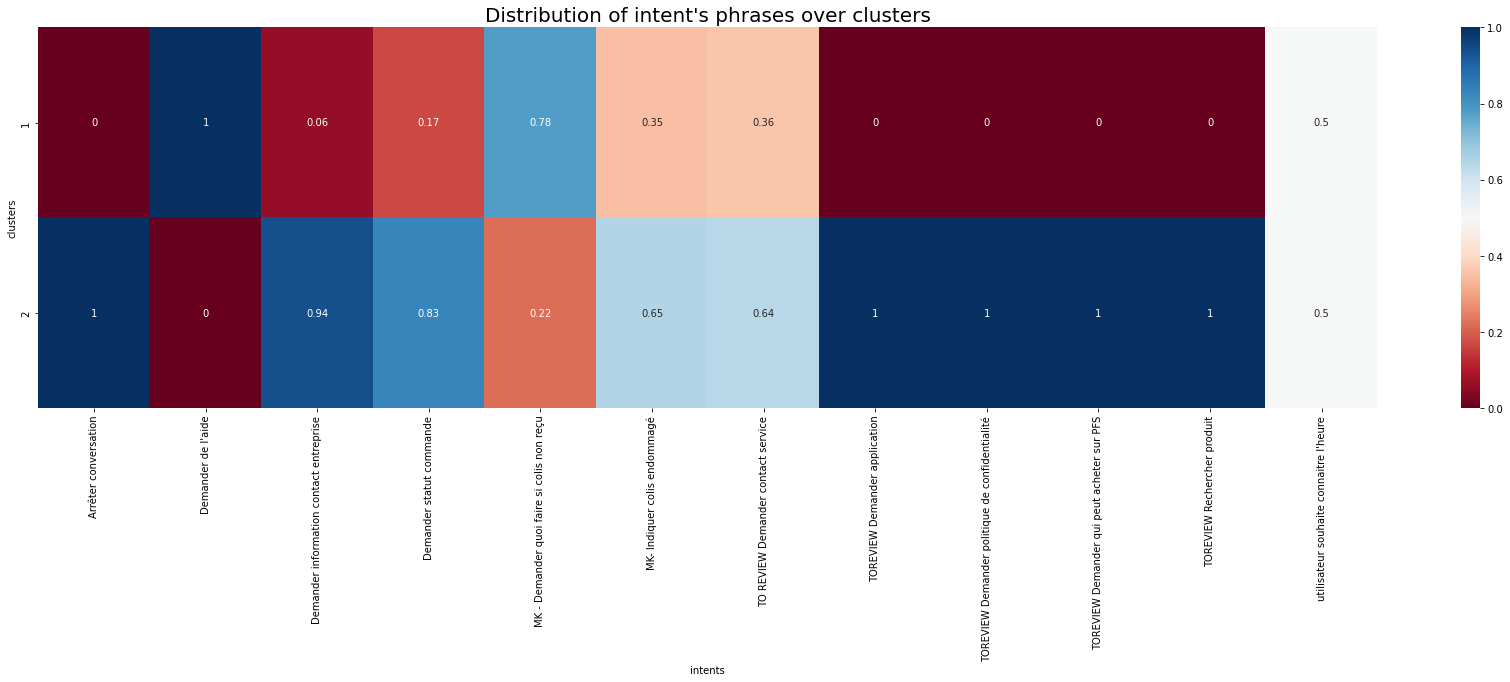

In [30]:
nb_clusters = 2
cluster_intents = k_means_clustering(bert_features, nb_clusters)
visualize_kmeans_clusters(cluster_intents)

With 2 clusters, we have more intents fully included in a cluster, i.e. 6 compared to 5 with 3 clusters. 

However, the other intents always cover multiple (two) clusters. 

Our conclusion is that with k-means algorithm applied on BERT features, we can not separate our data into independant clusters. 

We will explore some other type of features. 

# Annex

## Regroup intents using clusters features

The idea is to create a feature based on the previously detected clusters.
We will use the distribution of intent over clusters as the representation vector of each intent.

For example, the intent "Demander statut commande" has 17% data in the cluster 1 and 83% in the cluster 2, its representation vector will be [0.17, 0.83]. The representation of "Arrêter conversation" will be [0, 1]

Then we can apply clustering on the representations to identify group of similar intents.

In [44]:
def create_intent_features(all_intents_name, cluster_intents):
    intents_features = []
    for intent_ in all_intents_name:
        intent_features = []
        for cluster_id, intents_in_cluster in cluster_intents.items():
            if intent_ in intents_in_cluster:
                intent_features.append(round(intents_in_cluster[intent_] / nb_phrases_in_intents[intent_], 2))
            else:
                intent_features.append(0)
        intents_features.append(intent_features)
    return intents_features

In [45]:
def clustering(features, num_clusters):

    clustered_intents = [[] for i in range(num_clusters)]

    clustering_model = KMeans(n_clusters=num_clusters)
    clustering_model.fit(features)
    cluster_assignment = clustering_model.labels_

    for intent_id, cluster_id in enumerate(cluster_assignment):
        clustered_intents[cluster_id].append(all_intents_name[intent_id])

    return clustered_intents

In [46]:
intents_features = create_intent_features(all_intents_name, cluster_intents)
meta_clusters = clustering(intents_features, 6)

In [47]:
print(len(intents_features))
print(intents_features[0:10])

12
[[0.17, 0.83], [0.35, 0.65], [0, 1.0], [0, 1.0], [0, 1.0], [0.06, 0.94], [0, 1.0], [0.5, 0.5], [0.36, 0.64], [0.78, 0.22]]


Cluster: 1
Intents: Arrêter conversation, TOREVIEW Demander qui peut acheter sur PFS, TOREVIEW Demander politique de confidentialité, Demander information contact entreprise, TOREVIEW Rechercher produit, TOREVIEW Demander application


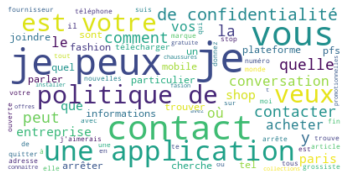

Cluster: 2
Intents: MK - Demander quoi faire si colis non reçu


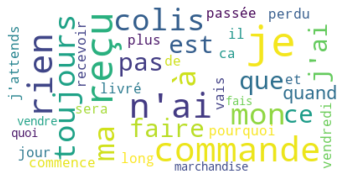

Cluster: 3
Intents: MK- Indiquer colis endommagé, TO REVIEW Demander contact service


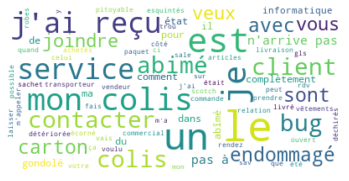

Cluster: 4
Intents: Demander de l'aide


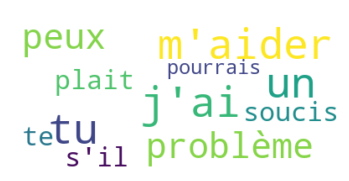

Cluster: 5
Intents: Demander statut commande


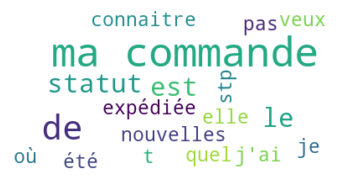

Cluster: 6
Intents: utilisateur souhaite connaitre l'heure


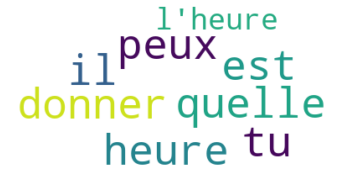

In [48]:
def get_phrases_of_intents_in_clusters(meta_clusters):
    phrases_in_clusters = []
    for cluster in meta_clusters: 
        phrases = []
        for intent_ in cluster:
            phrases.extend(get_phrases_of_intent(intent_))
        phrases_in_clusters.append(phrases)
    return phrases_in_clusters

def get_phrases_of_intent(intent_name):
    return [messages[i] for i in range(len(messages)) if intents[i] == intent_name]

from wordcloud import WordCloud

def display_words_cloud(meta_clusters, data):
    for i_c, c in enumerate(data):
        text = ' '.join([m.lower() for m in c])
        wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
        print('Cluster: {}'.format(i_c + 1))
        print(f'Intents: {", ".join(meta_clusters[i_c])}')
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()


res = get_phrases_of_intents_in_clusters(meta_clusters)
display_words_cloud(meta_clusters, res)

## `Clustering using SBERT features`

In [43]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

embedder = SentenceTransformer('distiluse-base-multilingual-cased')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/607 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/528 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

In [49]:
sbert_features = embedder.encode(messages)

In [50]:
cluster_intents = k_means_clustering(sbert_features, 3)

Cluster 1
	26 phrases
	10 classes
		Demander de l'aide : 3
			j'ai un problème, peux-tu m'aider ?
			tu peux m'aider s'il te plait ?
			tu pourrais m'aider ?
		TOREVIEW Demander qui peut acheter sur PFS : 4
			La plateforme est elle ouverte à tous ?
			tout le monde peut acheter ?
			qui peut acheter sur votre plateforme
			je peux acheter ?
		TOREVIEW Demander politique de confidentialité : 1
			quelle est votre politique de confidentialité ?
		TOREVIEW Demander application : 3
			avez-vous une application mobile que je peux télécharger ?
			y a une application gratuite que je peux installer ?
			y a une application mobile que je peux télécharger
		TOREVIEW Rechercher produit : 1
			quelles sont vos nouvelles collections ?
		TO REVIEW Demander contact service : 1
			Je n'arrive pas à vous joindre
		MK - Demander quoi faire si colis non reçu : 2
			Quand est-ce que je vais recevoir ma commande ? 
			commande  passée vendredi et toujours rien, j'ai plus de marchandise à vendre, je fais 

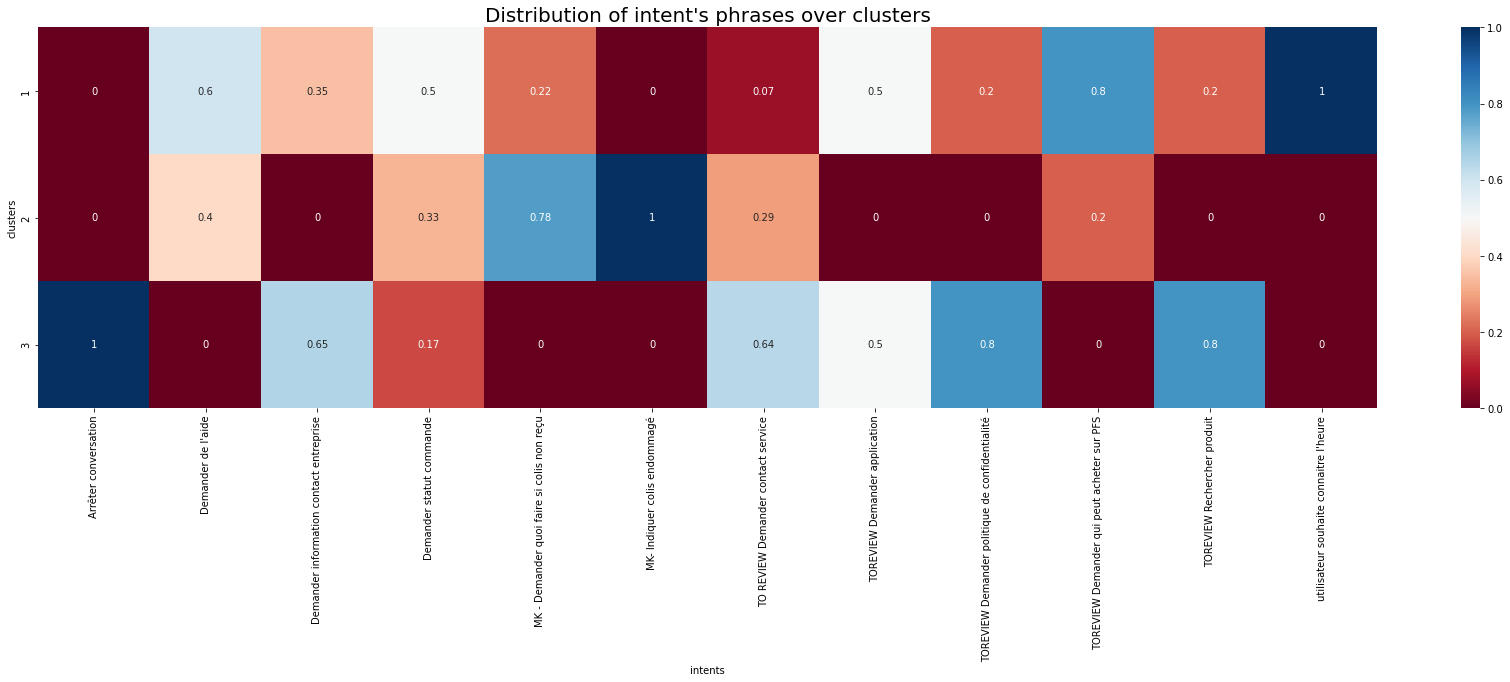

In [51]:
visualize_kmeans_clusters(cluster_intents)

[['MK- Indiquer colis endommagé', 'MK - Demander quoi faire si colis non reçu'], ['Demander information contact entreprise', 'TOREVIEW Demander application'], ['Arrêter conversation', 'TOREVIEW Demander politique de confidentialité', 'TOREVIEW Rechercher produit', 'TO REVIEW Demander contact service'], ['Demander statut commande', 'TOREVIEW Demander qui peut acheter sur PFS', "utilisateur souhaite connaitre l'heure", "Demander de l'aide"]]


Cluster: 1
Intents: MK- Indiquer colis endommagé, MK - Demander quoi faire si colis non reçu


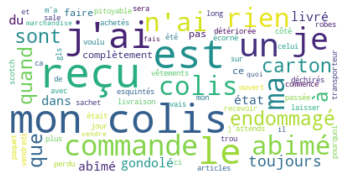

Cluster: 2
Intents: Demander information contact entreprise, TOREVIEW Demander application


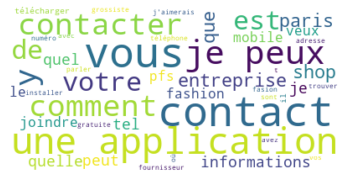

Cluster: 3
Intents: Arrêter conversation, TOREVIEW Demander politique de confidentialité, TOREVIEW Rechercher produit, TO REVIEW Demander contact service


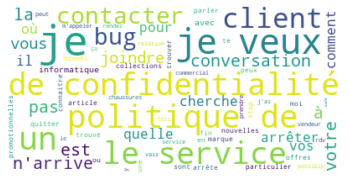

Cluster: 4
Intents: Demander statut commande, TOREVIEW Demander qui peut acheter sur PFS, utilisateur souhaite connaitre l'heure, Demander de l'aide


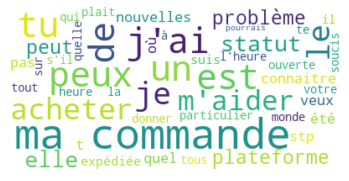

In [52]:
intents_features = create_intent_features(all_intents_name, cluster_intents)
meta_clusters = clustering(intents_features, 4)

print(meta_clusters)
print("\n")

res = get_phrases_of_intents_in_clusters(meta_clusters)
display_words_cloud(meta_clusters, res)

## Community detection using sentences-transformer

In [53]:
print(f"Encoding {len(messages)} messages ...")
corpus_embeddings = embedder.encode(messages, batch_size=64, show_progress_bar=True, convert_to_tensor=True)

Encoding 100 messages ...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [55]:
def find_clusters_by_community_detection(min_community_size=2, threshold=0.7):
    """
    #Two parameters to tune:
    #min_cluster_size: Only consider cluster that have at least 2 elements
    #threshold: Consider sentence pairs with a cosine-similarity larger than threshold as similar
    """
    
    intents_clusters = {} #{intent1: [cluster1, cluster2], intent2: [cluster3]}

    print(f"Encoding {len(messages)} messages ...")
    corpus_embeddings = embedder.encode(messages, batch_size=64, show_progress_bar=True, convert_to_tensor=True)

    clusters = util.community_detection(corpus_embeddings, min_community_size, threshold)
    print(f"Number of cluster : {len(clusters)}")

    clustered_messages = [[] for i in range(len(clusters))]

    for cluster_id in range(len(clusters)):
      for message_id in clusters[cluster_id]:
        clustered_messages[cluster_id].append((messages[message_id], intents[message_id]))

    for cluster_id, cluster in enumerate(clustered_messages):

        intents_in_cluster = [i for m, i in cluster]
        intents_counter = Counter(intents_in_cluster)

        display_cluster_id = cluster_id + 1

        for intent_ in intents_counter:
          if intent_ not in intents_clusters:
            intents_clusters[intent_] = [display_cluster_id]
          else:
            intents_clusters[intent_].append(display_cluster_id)

        print(f"Cluster {display_cluster_id}")
        print(f"\t{len(cluster)} phrases")
        print(f"\t{len(intents_counter)} classes")

        for intent_, count_ in intents_counter.items():
          print(f"\t\t{intent_} : {count_}")

        print(f"\t{cluster}")
        print("")


    print(intents_clusters)

    return intents_clusters

find_clusters_by_community_detection()